### 
Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from tensorflow import keras

# Load dataset
file_path = "Hospital Readmission Prediction.csv"  # Change path if necessary
df = pd.read_csv(file_path)
df

## 1. Show basic info
print("🔍 Dataset Overview:")
print(df.info())  # Dataset structure


In [4]:
# print("\n📝 First 5 rows:")
df.head()  # First 5 rows


,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to,readmitted
0,69,Male,Heart Disease,1,2,1,Home Health Care,0
1,32,Female,COPD,2,13,2,Rehabilitation Facility,0
2,89,Male,Diabetes,1,7,1,Home,0
3,78,Male,COPD,9,2,2,Skilled Nursing Facility,0
4,38,Male,Diabetes,6,4,4,Rehabilitation Facility,0


In [19]:
print("\n📊 Summary statistics:")
print(df.describe())  # Summary statistics




📊 Summary statistics:
               age  num_procedures  days_in_hospital  comorbidity_score  \
count  5000.000000      5000.00000       5000.000000        5000.000000   
mean     53.299000         4.46100          7.396600           2.068600   
std      20.646851         2.88606          4.025587           1.422357   
min      18.000000         0.00000          1.000000           0.000000   
25%      36.000000         2.00000          4.000000           1.000000   
50%      53.000000         4.00000          7.000000           2.000000   
75%      71.000000         7.00000         11.000000           3.000000   
max      89.000000         9.00000         14.000000           4.000000   

        readmitted  
count  5000.000000  
mean      0.188000  
std       0.390751  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  


In [21]:
# 2. Handle duplicates
print(f"\n❗ Duplicate Rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)  # Remove duplicates



❗ Duplicate Rows: 4


In [23]:

# 3. Handle missing values
missing_values = df.isnull().sum()
print("\n🛑 Missing Values per Column:\n", missing_values[missing_values > 0])
# Drop rows with missing target variable
df.dropna(subset=['readmitted'], inplace=True)


🛑 Missing Values per Column:
 Series([], dtype: int64)


C:\Users\mohaa\AppData\Local\Temp\ipykernel_7020\3049145002.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='gender', palette='coolwarm')


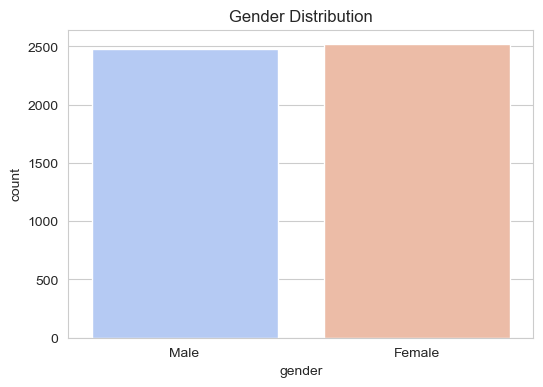

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Step 2: Gender Distribution Visualization
# Set plot style
sns.set_style("whitegrid")

# 1. Gender Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='gender', palette='coolwarm')
plt.title("Gender Distribution")
plt.show()



C:\Users\mohaa\AppData\Local\Temp\ipykernel_7020\836614639.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='readmitted', palette='viridis')


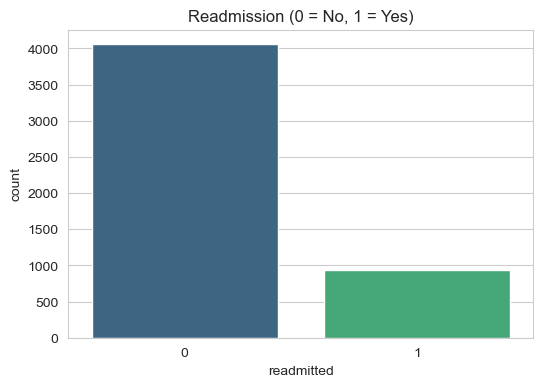

In [27]:
# 2. Readmission Rate
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='readmitted', palette='viridis')
plt.title("Readmission (0 = No, 1 = Yes)")
plt.show()



C:\Users\mohaa\AppData\Local\Temp\ipykernel_7020\424939983.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='primary_diagnosis', order=df['primary_diagnosis'].value_counts().index, palette='pastel')


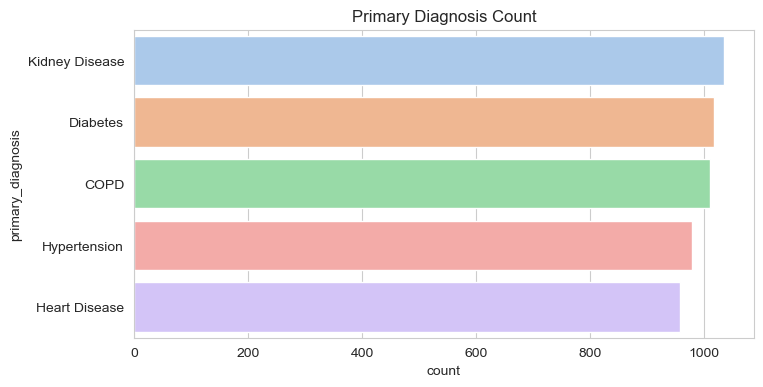

In [29]:
# 3. Primary Diagnosis
plt.figure(figsize=(8,4))
sns.countplot(data=df, y='primary_diagnosis', order=df['primary_diagnosis'].value_counts().index, palette='pastel')
plt.title("Primary Diagnosis Count")
plt.show()



In [80]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
encoder = LabelEncoder()

# Convert categorical columns
categorical_columns = ['gender', 'primary_diagnosis', 'discharge_to', 'readmitted']

for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

# Show updated dataset
df.head()


,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to,readmitted
0,51,1,2,1,2,1,1,0
1,14,0,0,2,13,2,2,0
2,71,1,1,1,7,1,0,0
3,60,1,0,9,2,2,3,0
4,20,1,1,6,4,4,2,0


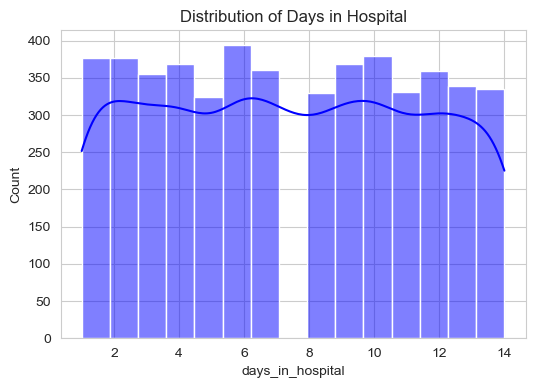

In [33]:
# 4. Days in Hospital Distribution
plt.figure(figsize=(6,4))
sns.histplot(df['days_in_hospital'], bins=15, kde=True, color='blue')
plt.title("Distribution of Days in Hospital")
plt.show()


In [82]:

# Encode categorical variables
label_encoders = {}
categorical_columns = ['gender', 'primary_diagnosis', 'discharge_to']
df_encoded = df.copy()

for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le



In [84]:
df.head(70)

,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to,readmitted
0,51,1,2,1,2,1,1,0
1,14,0,0,2,13,2,2,0
2,71,1,1,1,7,1,0,0
3,60,1,0,9,2,2,3,0
4,20,1,1,6,4,4,2,0
...,...,...,...,...,...,...,...,...
65,71,1,0,5,14,2,3,0
66,61,1,0,2,9,0,0,1
67,39,1,2,0,4,0,0,0
68,52,1,4,7,7,4,2,0


In [86]:
# Define features and target variable
X = df_encoded.drop(columns=['readmitted'])
y = df_encoded['readmitted']

# Handle class imbalance using Oversampling
df_majority = df_encoded[df_encoded.readmitted == 0]
df_minority = df_encoded[df_encoded.readmitted == 1]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)



In [18]:
# Split data
X_balanced = df_balanced.drop(columns=['readmitted'])
y_balanced = df_balanced['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [32]:
# # Feature Scaling
# print("\n⚖️ Feature Scaling: Standardization")

# # Identify numerical columns for scaling
# numerical_columns = df_encoded.select_dtypes(include=np.number).columns.tolist()
# numerical_columns.remove('readmitted')  # Exclude the target variable

# # Initialize the scaler
# scaler = StandardScaler()

# # Apply scaling
# X_balanced_scaled = df_balanced.copy()
# X_balanced_scaled[numerical_columns] = scaler.fit_transform(df_balanced[numerical_columns])

# # Split data after scaling
# X_train, X_test, y_train, y_test = train_test_split(
#     X_balanced_scaled.drop(columns=['readmitted']), 
#     X_balanced_scaled['readmitted'], 
#     test_size=0.2, 
#     random_state=42
# )

# print("✅ Feature Scaling Completed.")


In [20]:
# ------------------------------
# Feature Scaling
# ------------------------------

from sklearn.preprocessing import StandardScaler
import joblib

# Initialize StandardScaler
sc = StandardScaler()

# Apply scaling to training and test sets
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Save the scaler for future use (e.g., in deployment)
joblib.dump(sc, 'StandardScaler_many.pkl')

print("\n✅ Feature Scaling Completed and Scaler Saved!")



✅ Feature Scaling Completed and Scaler Saved!


In [22]:
# Train Logistic Regression next
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_score_lr = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1])
print(f"\nLogistic Regression:\n", classification_report(y_test, y_pred_lr))
print(f"Logistic Regression -> Accuracy: {accuracy_lr:.4f}, AUC Score: {auc_score_lr:.4f}")



Logistic Regression:
               precision    recall  f1-score   support

           0       0.52      0.48      0.50       822
           1       0.51      0.55      0.53       802

    accuracy                           0.51      1624
   macro avg       0.52      0.52      0.51      1624
weighted avg       0.52      0.51      0.51      1624

Logistic Regression -> Accuracy: 0.5148, AUC Score: 0.5283


In [47]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_score_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
print(f"\nXGBoost:\n", classification_report(y_test, y_pred_xgb))
print(f"XGBoost -> Accuracy: {accuracy_xgb:.4f}, AUC Score: {auc_score_xgb:.4f}")



XGBoost:
               precision    recall  f1-score   support

           0       0.91      0.79      0.85       791
           1       0.82      0.93      0.87       832

    accuracy                           0.86      1623
   macro avg       0.87      0.86      0.86      1623
weighted avg       0.87      0.86      0.86      1623

XGBoost -> Accuracy: 0.8601, AUC Score: 0.9267


C:\Users\mohaa\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:01:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [49]:
# Train LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
auc_score_lgb = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:,1])
print(f"\nLightGBM:\n", classification_report(y_test, y_pred_lgb))
print(f"LightGBM -> Accuracy: {accuracy_lgb:.4f}, AUC Score: {auc_score_lgb:.4f}")


C:\Users\mohaa\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3224, number of negative: 3265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 6489, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496841 -> initscore=-0.012637
[LightGBM] [Info] Start training from score -0.012637

LightGBM:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76       791
           1       0.76      0.81      0.79       832

    accuracy                           0.77      1623
   macro avg       0.78      0.77      0.77      1623
weighted avg       0.77      0.77      0.77      1623

LightGBM -> Accuracy: 0.7739, AUC Score: 0.8484


C:\Users\mohaa\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mohaa\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [51]:
# Train Neural Network
nn_model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1, validation_data=(X_test, y_test))


C:\Users\mohaa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5008 - loss: 0.7139 - val_accuracy: 0.5059 - val_loss: 0.6937
Epoch 2/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5409 - loss: 0.6884 - val_accuracy: 0.5003 - val_loss: 0.6914
Epoch 3/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5320 - loss: 0.6894 - val_accuracy: 0.5089 - val_loss: 0.6944
Epoch 4/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5453 - loss: 0.6869 - val_accuracy: 0.5305 - val_loss: 0.6889
Epoch 5/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5531 - loss: 0.6864 - val_accuracy: 0.5114 - val_loss: 0.6891
Epoch 6/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5668 - loss: 0.6826 - val_accuracy: 0.5330 - val_loss: 0.6883
Epoch 7/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5659 - loss: 0.6818 - val_accuracy: 0.5484 - val_loss: 0.6866
Epoch 8/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5656 - loss: 0.6820 - val_accuracy: 0

In [53]:
# Train Random Forest first
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_score_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])
print(f"\nRandom Forest:\n", classification_report(y_test, y_pred_rf))
print(f"Random Forest -> Accuracy: {accuracy_rf:.4f}, AUC Score: {auc_score_rf:.4f}")



Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       791
           1       0.94      0.96      0.95       832

    accuracy                           0.95      1623
   macro avg       0.95      0.95      0.95      1623
weighted avg       0.95      0.95      0.95      1623

Random Forest -> Accuracy: 0.9476, AUC Score: 0.9804


In [76]:
# # Print all model results
# print("\nFinal Model Performance:")
# for model, scores in results.items():
#     print(f"{model} -> Accuracy: {scores['Accuracy']:.4f}, AUC Score: {scores.get('AUC Score', 'N/A')}")


In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search CV
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Accuracy: 0.9288039365467068


In [80]:
# Train the final Random Forest model with the best hyperparameters
best_rf = RandomForestClassifier(
    max_depth=None, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=300, 
    random_state=42
)

best_rf.fit(X_train, y_train)

# Evaluate on the test set
y_pred_final = best_rf.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(f"Final Test AUC Score: {final_auc:.4f}")


Final Test Accuracy: 0.9489
Final Test AUC Score: 0.9800


In [24]:
# Load the saved encoders, scaler, and model
import numpy as np
import pandas as pd
import joblib  # Ensure you have this installed

# Load trained model (replace 'model.pkl' with your actual model filename)
model = joblib.load("model.pkl")

# Load training data (if needed)
# X = pd.read_csv("training_data.csv")  # Uncomment if necessary

# Check feature names used in training
print("Feature Names in Training Data:", model.feature_names_in_)

# Define a new patient sample matching feature names
new_patient = {
    'age': 62,  
    'gender': 1,  
    'primary_diagnosis': 0,  
    'discharge_to':2,  
    'num_procedures':9,  
    'days_in_hospital': 6,  
    'comorbidity_score': 2,  # Placeholder value (ensure it's realistic)
}

# Convert to DataFrame
new_patient_df = pd.DataFrame([new_patient])

# Ensure column order matches training data
new_patient_df = new_patient_df.reindex(columns=model.feature_names_in_, fill_value=0)

# Make prediction
predicted_readmission = model.predict(new_patient_df)
predicted_probability = model.predict_proba(new_patient_df)[:, 1]

# Output results
print("Predicted Readmission (0 = No, 1 = Yes):", predicted_readmission[0])
print("Readmission Probability:", predicted_probability[0])


Feature Names in Training Data: ['age' 'gender' 'primary_diagnosis' 'discharge_to' 'num_procedures'
 'days_in_hospital' 'comorbidity_score']
Predicted Readmission (0 = No, 1 = Yes): 1
Readmission Probability: 0.59


# import joblib

# Save trained model
joblib.dump(best_rf, 'random_forest_model.pkl')

# Save feature scaler 
joblib.dump(scaler, 'scaler.pkl')

# Save label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')
